In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from kmodes.kmodes import KModes

In [2]:
table_nm = 'DLAB_INTERN_TR_IFO_TMP' 
names = ['iqr_dt','cus_no','act_no','mkt_gb','pdt_gb','iem_cd','iem_krl_anm','bnc_qty','tot_aet_amt'] 

file_path = f'/home/sbx/data/DATA0113/DATA/{table_nm}.csv' 
df_trd = pd.read_csv(file_path,  names = names) 
df_trd.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,iqr_dt,cus_no,act_no,mkt_gb,pdt_gb,iem_cd,iem_krl_anm,bnc_qty,tot_aet_amt
0,20210510,7367714,20401262584,국내,주식,A027360,아주IB투자,25,177000
1,20210519,7367714,20401262584,국내,주식,A027360,아주IB투자,25,173250
2,20210522,7367714,20401262584,국내,주식,A027360,아주IB투자,25,177000
3,20210518,7367714,20401262584,국내,주식,A027360,아주IB투자,25,173250
4,20210609,7367714,20401262584,국내,주식,A027360,아주IB투자,25,197500


In [3]:
table_nm = 'DLAB_HT_L1_CUS_IFO_TMP' 
names = ['cus_no','sex_dit_cd','cus_age','zip_ctp_cd', 'tco_cus_grd_cd', 'ivs_icn_cd'] 

file_path = f'/home/sbx/data/DATA0113/DATA/{table_nm}.csv' 
df_cus = pd.read_csv(file_path,  names = names) 
df_cus.head()

,cus_no,sex_dit_cd,cus_age,zip_ctp_cd,tco_cus_grd_cd,ivs_icn_cd
0,103139301,2,29,44,05,02
1,102997409,2,27,11,09,04
2,103481357,2,30,31,09,-
3,104565295,2,25,28,09,03
4,102932829,2,28,11,05,03


In [4]:
table_nm = 'DLAB_HT_L1_ACT_IFO_TMP' 
names = ['act_no','cus_no','act_opn_ym'] 

file_path = f'/home/sbx/data/DATA0113/DATA/{table_nm}.csv' 
df_act = pd.read_csv(file_path,  names = names) 
df_act.head()

,act_no,cus_no,act_opn_ym
0,20403262584,7367714,202102
1,20404262584,7367714,202102
2,20401262584,7367714,202102
3,9088211594,7367714,200511
4,20402262584,7367714,202102


In [5]:
# Making and cleaning data set to cluster
df_bal = df_trd.copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal = df_bal.reset_index()

df_bal_kor = df_trd[df_trd['mkt_gb'] == '국내'].copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal_kor = df_bal_kor.reset_index()

df_bal_ovs = df_trd[df_trd['mkt_gb'] == '해외'].copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal_ovs = df_bal_ovs.reset_index()

df_bal_tot = pd.merge(left=df_bal, 
                      right=df_bal_kor[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_kr'), 
                      how='left')
df_bal_tot = pd.merge(left=df_bal_tot, 
                      right=df_bal_ovs[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_ov'), 
                      how='left')

df_bal_tot[['tot_aet_amt_kr', 'tot_aet_amt_ov']] = df_bal_tot[['tot_aet_amt_kr', 'tot_aet_amt_ov']].fillna(0)

bank_cus = pd.merge(left=df_cus, right = df_bal_tot, on='cus_no', suffixes=('',''))
bank_cus['ovs_ratio'] = bank_cus['tot_aet_amt_ov']/bank_cus['tot_aet_amt']

In [6]:
df_bal_list = []
df_bal_len = []
df_cus_w = df_cus.copy()[(df_cus['cus_no'].isin(df_trd['cus_no'])) & ~(df_cus['cus_no'].isin(df_trd[(df_trd['iem_cd'] == "US25459W4583")]['cus_no']))]
for i in df_bal_tot['iqr_dt'].unique():
    df = df_bal_tot[df_bal_tot['iqr_dt'] == i]
    df = pd.merge(left=df_cus_w, right=df, on='cus_no', suffixes=('','')) #if how='left', customers who haven't opened an account appear
    df['ovs_ratio'] = df['tot_aet_amt_ov'] / df['tot_aet_amt']
    df_bal_list.append(df)
    df_bal_len.append(len(df))

In [7]:
df_bal_list_10_19 = []
df_bal_list_20_24 = []
df_bal_list_25_30 = []
for i in range(len(df_bal_list)):
    df_bal_list_10_19.append(df_bal_list[i][(df_bal_list[i]['cus_age'] > 9) & (df_bal_list[i]['cus_age'] < 20)])
    df_bal_list_20_24.append(df_bal_list[i][(df_bal_list[i]['cus_age'] > 19) & (df_bal_list[i]['cus_age'] < 25)])
    df_bal_list_25_30.append(df_bal_list[i][(df_bal_list[i]['cus_age'] > 24) & (df_bal_list[i]['cus_age'] < 31)])

In [8]:
#20대 초반 투자자 해외투자 비중 변화
#20대 초반 투자자 해외투자액 변화

df_list = df_bal_list_20_24
num_ppl = []
ovs_pct = []
ovs_pct_ratio = []
ovs_avg_ratio = []
ovs_tot_amt = []
for i in range(182):
    df = df_list[i]
    df_hlf = df[df['ovs_ratio'] > 0.5]
    df_ovs = df[df['ovs_ratio'] > 0]
    ovs_pct.append(len(df[df['ovs_ratio'] > 0])/len(df))
    ovs_pct_ratio.append(len(df_hlf)/len(df_ovs))
    ovs_avg_ratio.append(df_ovs['ovs_ratio'].mean())
    ovs_tot_amt.append(df['tot_aet_amt_ov'].sum())
# pd.DataFrame(ovs_pct).plot()
# pd.DataFrame(ovs_tot_amt).plot()
# len(df_list[1])

In [9]:
# Combining the dataset into one dataframe
df_bank_cus = pd.concat([df_bal_list_10_19[181],df_bal_list_20_24[181],df_bal_list_25_30[181]], axis=0)
df_bank_cus
print()

In [10]:
# Cleaning df_bank_cus for clustering

df_bank_cus_copy = df_bank_cus.copy()

# r = np.array([0, 19, 24, 31])
# df_bank_cus_copy['cus_age'] = pd.cut(df_bank_cus_copy['cus_age'], r)
# df_bank_cus_copy.head()

df_bank_cus_copy = df_bank_cus_copy.drop(columns=['cus_no','ivs_icn_cd', 'iqr_dt', 'tot_aet_amt_kr', 'tot_aet_amt_ov','tco_cus_grd_cd'])
df_bank_cus_copy.head()

,sex_dit_cd,cus_age,zip_ctp_cd,tot_aet_amt,ovs_ratio
8,1,13,44,4862500,0.000000
19,1,17,11,17364000,0.000000
22,1,16,30,7483126,0.989296
36,2,13,44,568200,0.000000
37,1,15,41,27527500,0.000000


In [11]:
# Choosing K 
cost = []
for clusters in list(range(1,8)):
    modes = KModes(n_clusters=clusters, init = "Random", n_init=1, verbose=1)
    modes.fit_predict(df_bank_cus_copy)
    cost.append(modes.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1344.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 58, cost: 1157.0
Run 1, iteration: 2/100, moves: 3, cost: 1157.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 122, cost: 1123.0
Run 1, iteration: 2/100, moves: 4, cost: 1123.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 14, cost: 1140.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 58, cost: 1087.0
Run 1, iteration: 2/100, moves: 14, cost: 1087.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 93, cost: 1045.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
R

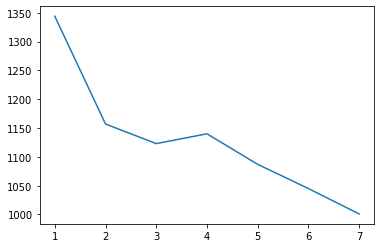

In [12]:
graph = np.array([i for i in range (1,8,1)])
plt.plot(graph, cost)
#Choose K = 5

In [13]:
# KModes clustering ran 10 times with K=5
km = KModes(n_clusters=5, init="Random", n_init=10, verbose=1)
fit_clusters = km.fit_predict(df_bank_cus_copy)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 80, cost: 1054.0
Run 1, iteration: 2/100, moves: 0, cost: 1054.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 119, cost: 1097.0
Run 2, iteration: 2/100, moves: 22, cost: 1097.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 103, cost: 1066.0
Run 3, iteration: 2/100, moves: 21, cost: 1065.0
Run 3, iteration: 3/100, moves: 0, cost: 1065.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 144, cost: 1071.0
Run 4, iteration: 2/100, moves: 1, cost: 1071.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 181, cost: 1039.0
Run 5, iteration: 2/100, moves: 19, cost: 1039.0
Init: initializing centroids
Init: initializing clusters
Sta

In [14]:
# Combine the clusters with df_bank_cus_copy
df_bank_cus_copy.head()
cluster_prediction = pd.DataFrame(fit_clusters)
cluster_prediction.columns = ['cluster_predict']
df_bank_cus_final = pd.concat([df_bank_cus_copy, cluster_prediction], axis=1)
# df_bank_cus_final = df_bank_cus_final.drop(['index'])
df_bank_cus_final.head()

,sex_dit_cd,cus_age,zip_ctp_cd,tot_aet_amt,ovs_ratio,cluster_predict
0,2,29,44,21178116,0.076724,1
1,2,27,11,1230805,0.000000,3
2,2,30,31,2402250,0.000000,1
3,2,25,28,268070,0.364718,0
4,2,28,11,10191874,0.236793,2


In [15]:
# Grouping the Values as a group

r_tot = np.array([0, 100000, 300000, 1000000, 3000000, 10000000, 30000000, 100000000, 1000000000])
df_bank_cus_final['tot_aet_amt'] = pd.cut(df_bank_cus_final['tot_aet_amt'], r_tot)

r_age = np.array([0, 19, 24, 31])
df_bank_cus_final['cus_age'] = pd.cut(df_bank_cus_final['cus_age'], r_age)

r_ovs = np.array([-1, 0, 0.2, 0.4, 0.6, 0.8, 1])
df_bank_cus_final['ovs_ratio'] = pd.cut(df_bank_cus_final['ovs_ratio'], r_ovs)
df_bank_cus_final.head()


,sex_dit_cd,cus_age,zip_ctp_cd,tot_aet_amt,ovs_ratio,cluster_predict
0,2,"(24, 31]",44,"(10000000, 30000000]","(0.0, 0.2]",1
1,2,"(24, 31]",11,"(1000000, 3000000]","(-1.0, 0.0]",3
2,2,"(24, 31]",31,"(1000000, 3000000]","(-1.0, 0.0]",1
3,2,"(24, 31]",28,"(100000, 300000]","(0.2, 0.4]",0
4,2,"(24, 31]",11,"(10000000, 30000000]","(0.2, 0.4]",2


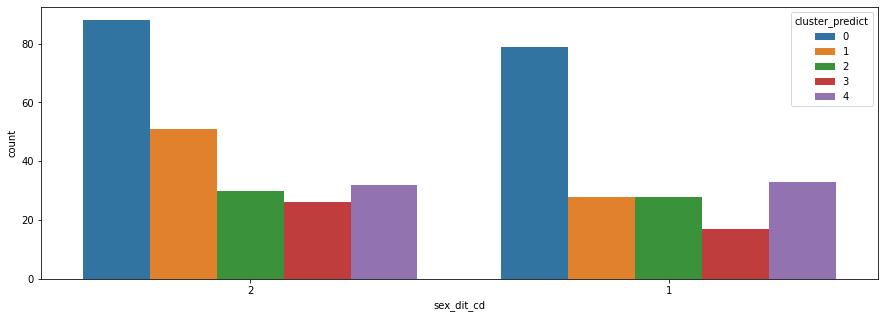

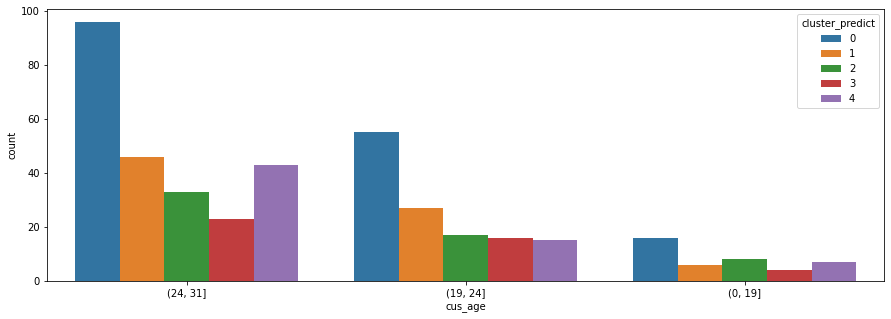

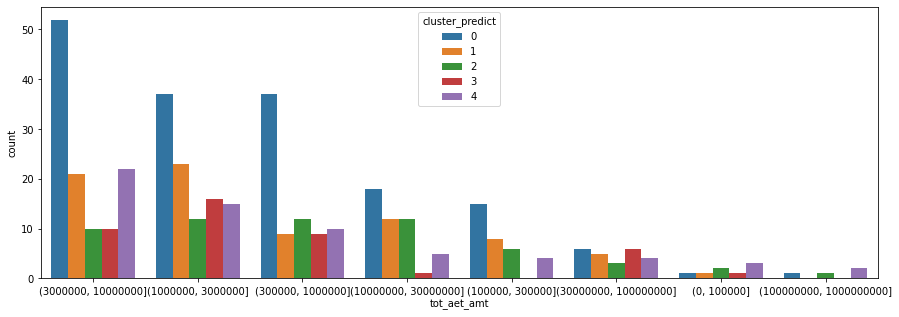

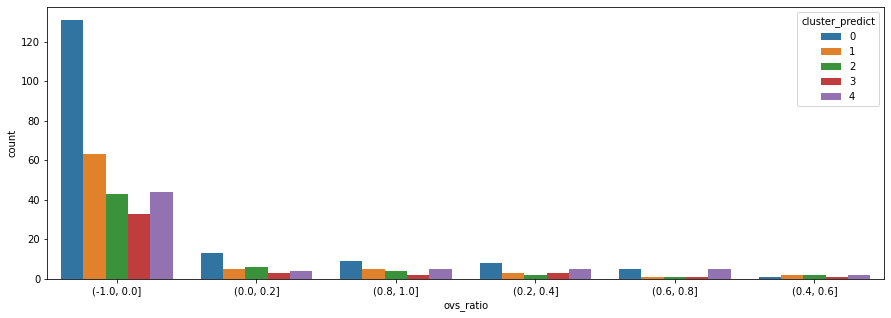

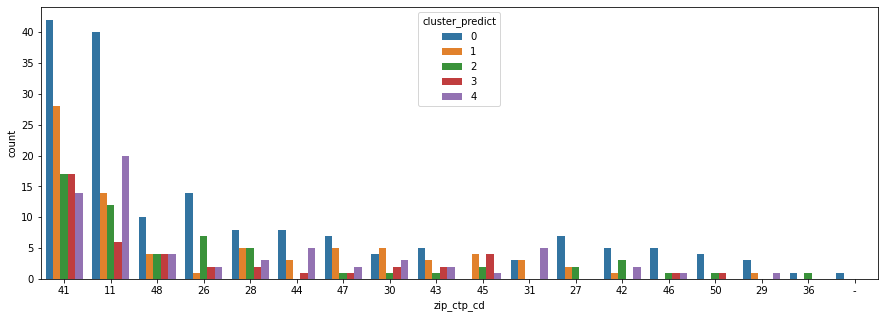

In [18]:
# Visualizing 

plt.subplots(figsize= (15,5))
sns.countplot(x=df_bank_cus_final['sex_dit_cd'], order=df_bank_cus_final['sex_dit_cd'].value_counts().index, hue=df_bank_cus_final['cluster_predict'])
plt.show()

plt.subplots(figsize= (15,5))
sns.countplot(x=df_bank_cus_final['cus_age'], order=df_bank_cus_final['cus_age'].value_counts().index, hue=df_bank_cus_final['cluster_predict'])
plt.show()

plt.subplots(figsize= (15,5))
sns.countplot(x=df_bank_cus_final['tot_aet_amt'], order=df_bank_cus_final['tot_aet_amt'].value_counts().index, hue=df_bank_cus_final['cluster_predict'])
plt.show()

plt.subplots(figsize= (15,5))
sns.countplot(x=df_bank_cus_final['ovs_ratio'], order=df_bank_cus_final['ovs_ratio'].value_counts().index, hue=df_bank_cus_final['cluster_predict'])
plt.show()

plt.subplots(figsize= (15,5))
sns.countplot(x=df_bank_cus_final['zip_ctp_cd'], order=df_bank_cus_final['zip_ctp_cd'].value_counts().index, hue=df_bank_cus_final['cluster_predict'])
plt.show()


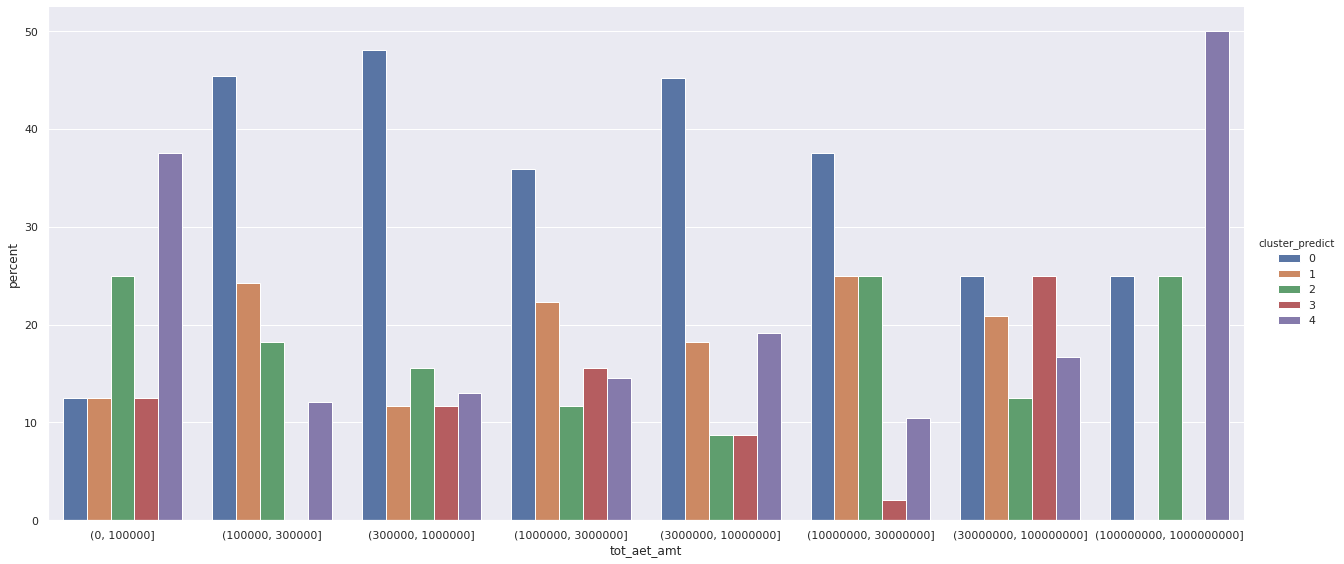

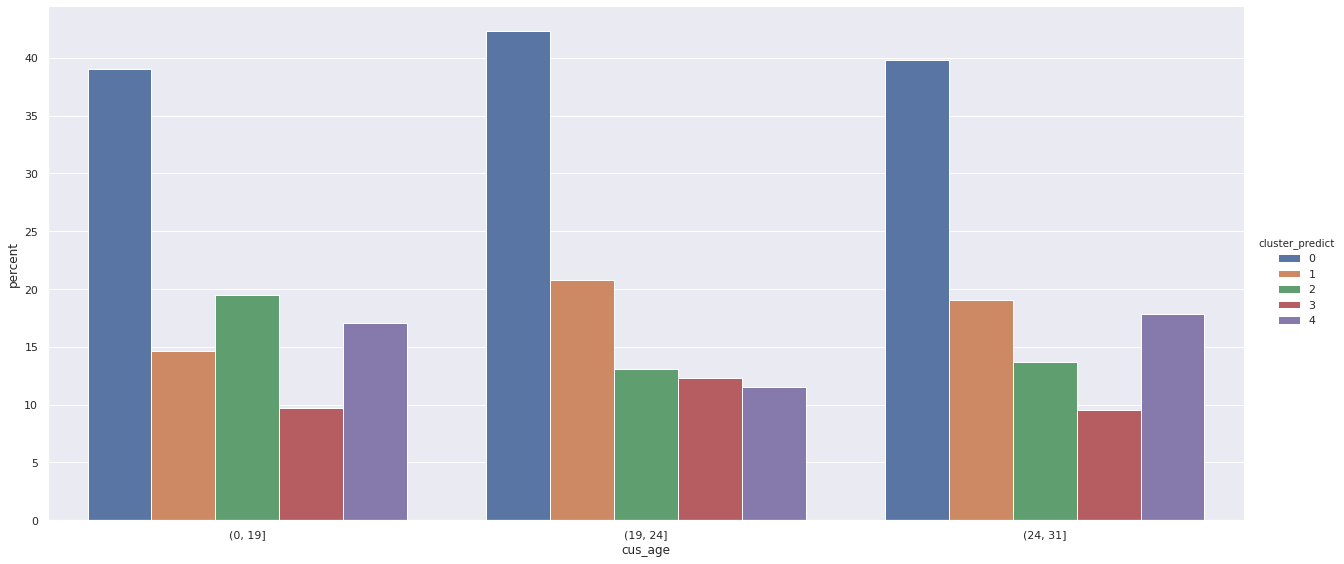

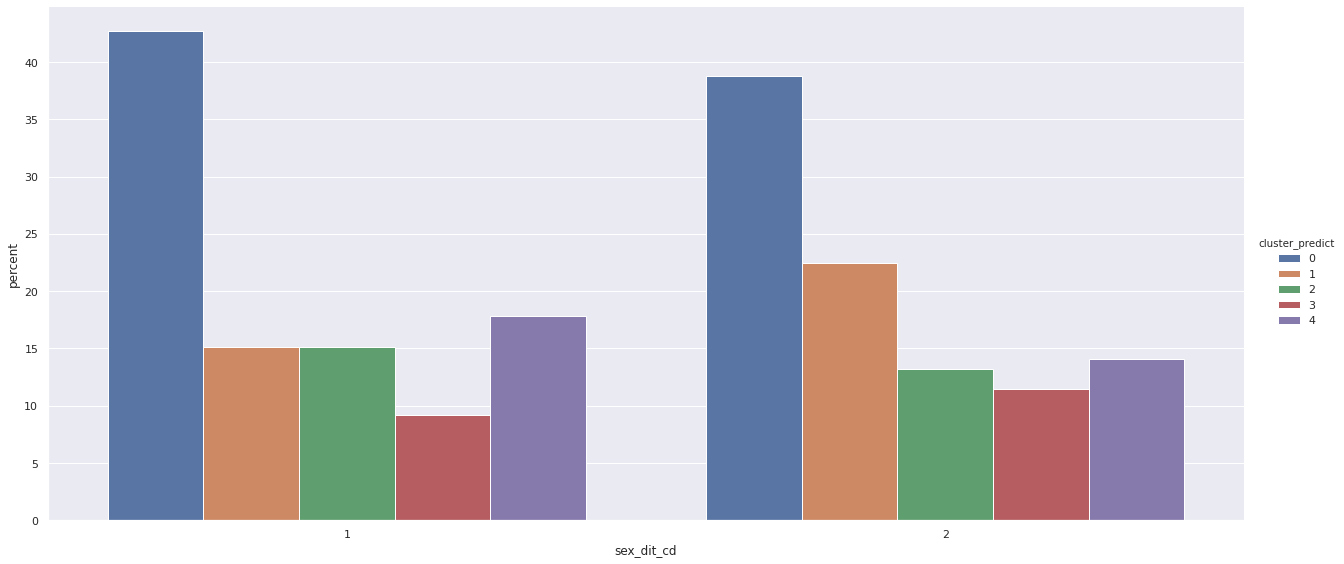

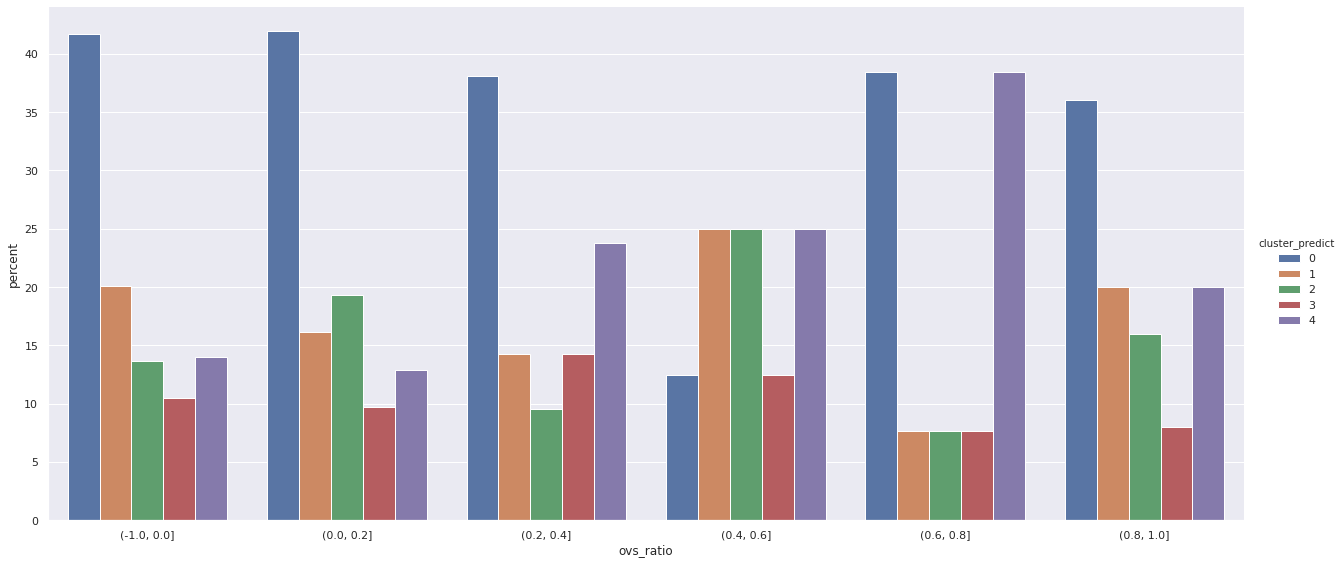

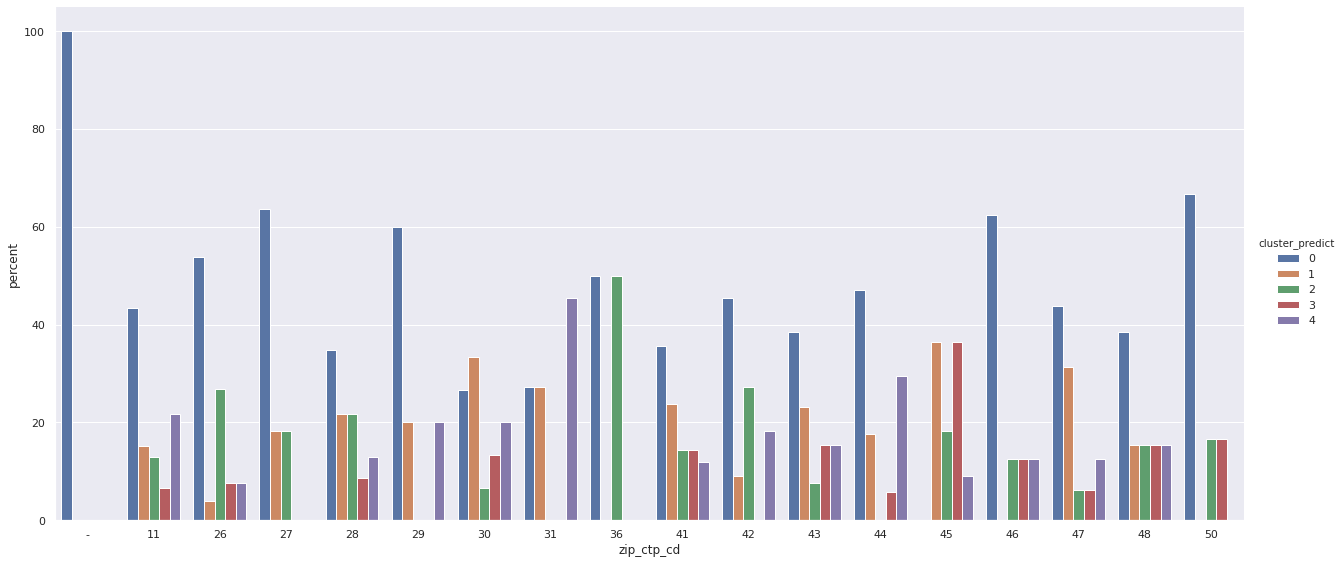

In [48]:
# Visualization based on proportion

df_bank_cus_final.groupby('tot_aet_amt')['cluster_predict'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x='tot_aet_amt',y='percent',hue='cluster_predict',kind='bar', height=8, aspect = 2.2)
plt.show()

df_bank_cus_final.groupby('cus_age')['cluster_predict'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x='cus_age',y='percent',hue='cluster_predict',kind='bar', height=8, aspect = 2.2)
plt.show()

df_bank_cus_final.groupby('sex_dit_cd')['cluster_predict'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x='sex_dit_cd',y='percent',hue='cluster_predict',kind='bar', height=8, aspect = 2.2)
plt.show()

df_bank_cus_final.groupby('ovs_ratio')['cluster_predict'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x='ovs_ratio',y='percent',hue='cluster_predict',kind='bar', height=8, aspect = 2.2)
plt.show()

df_bank_cus_final.groupby('zip_ctp_cd')['cluster_predict'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x='zip_ctp_cd',y='percent',hue='cluster_predict',kind='bar', height=8, aspect = 2.2)
plt.show()

In [50]:
df_trd[df_trd['iqr_dt'] == 20210701].groupby('iem_krl_anm').count().sort_values(by='iqr_dt', ascending=False).head()

,iqr_dt,cus_no,act_no,mkt_gb,pdt_gb,iem_cd,bnc_qty,tot_aet_amt
iem_krl_anm,,,,,,,,
삼성전자,205,205,205,205,205,205,205,205
삼성전자우,67,67,67,67,67,67,67,67
카카오,62,62,62,62,62,62,62,62
대한항공,47,47,47,47,47,47,47,47
애플,30,30,30,30,30,30,30,30


In [53]:
cluster_0 = df_bank_cus_final[df_bank_cus_final['cluster_predict'] == 0]
cluster_0

,sex_dit_cd,cus_age,zip_ctp_cd,tot_aet_amt,ovs_ratio,cluster_predict
3,2,"(24, 31]",28,"(100000, 300000]","(0.2, 0.4]",0
6,1,"(24, 31]",28,"(300000, 1000000]","(0.0, 0.2]",0
10,2,"(19, 24]",11,"(1000000, 3000000]","(-1.0, 0.0]",0
11,1,"(24, 31]",43,"(10000000, 30000000]","(-1.0, 0.0]",0
12,1,"(24, 31]",-,"(10000000, 30000000]","(-1.0, 0.0]",0
15,2,"(24, 31]",41,"(1000000, 3000000]","(-1.0, 0.0]",0
20,1,"(19, 24]",11,"(3000000, 10000000]","(0.0, 0.2]",0
22,1,"(0, 19]",30,"(3000000, 10000000]","(0.8, 1.0]",0
24,2,"(24, 31]",31,"(100000, 300000]","(-1.0, 0.0]",0
28,1,"(24, 31]",27,"(1000000, 3000000]","(-1.0, 0.0]",0
